# HF all-band tuneable bandpass filter
Last update: 24 Jan 2026

This notebook attempts to answer a question posted on electronics stackexchange and linked here: [How are the shunt coupling capacitors chosen in this double-tuned HF bandpass filter, and how do they affect the resonance and bandwidth?](https://electronics.stackexchange.com/questions/760482/how-are-the-shunt-coupling-capacitors-chosen-in-this-double-tuned-hf-bandpass-fi). The question asked on Nov 9, 2025

Below is the schematic of the filter.

![](xFMQAjoi.png)

Summary of what was asked:

  - How are the shunt coupling capacitors chosen mathematically? I am specifically asking for a practical calculation or rule-of-thumb (even approximate) that relates. How do these shunt coupling capacitors change the filter topology and response, compared to a single LC band-pass?
  - If I only used the series inductor + variable capacitor, the circuit would already behave as a tunable series resonant band-pass.
  - What changes mathematically when the second resonator and shunt coupling capacitors are present?
  - Do these changes make this circuit act something like a second order band-pass? Why? If I add as much resonator as I want with couplings without any reason does it still make a better filter?

---

Having read the question, linked reference material and reviewing the comments provided, the following are my proposed answers. 

## Question 1
The first question @AsahiKuro asked was:
> How are the shunt coupling capacitors chosen mathematically? I am specifically asking for a practical calculation or rule-of-thumb (even approximate) that relates.

As others have suggested, a circuit simulator could be used to find a shunt capacitance value that meets the design goals. By repeated analysis you can converge on a solution. However, @AsahiKuro specifically asked for a mathematical approach.  

I'll rephrase the first question from @AsahiKuro to make it a little more general - given the filter's topology, how can the element values be chosen for each HF Ham Band? 

To answer this question, I'll present some calculations that were performed using Python in a JupyterLab notebook; the link to my notebook on GitHub is [here](https://github.com/Tiburonboy/EE_jupyter_notebooks/blob/main/HF_all-band_tuneable_bandpass_filter/HF_all-band_tuneable_bandpass_filter.ipynb). What you see below are sections of the notebook converted to markdown and pasted into the answer dialog box.    

Solution steps:

1. Draw a simplified schematic of the filter.
1. Determine the characteristic polynominal using normalized component values.
1. Solve for the value of shunt capacitor, $C$, satisfying $\omega _o$, and other constraints. 
1. Frequency and impedance scale the normalized values.
1. Plot the frequency response.
1. Verify the results with LTSpice.

## 1) Draw the Schematic
I re-drew the schematic to remove the switches, combine the inductors and capacitors, add reference designators and node numbers. Ignoring the bypass switches, $SW_1$ and $SW_8$, $L_1$ in the schematic below represents the series combination of the three inductors. Depending on the combination of the switch states ($SW_2$ and $SW_3$), $L_1$ takes on a discrete value. In the analysis that follows, $L_1$, represents any value which can later be converted to discrete values to be switched in or out of the circuit. $L_2$ is the series combination of the three inductors combined by switches $SW_6$ and $SW_7$ and $C$ is the parallel combination of the capacitors selected by switches $SW_4$ and $SW_5$. $C_1$ and $C_2$ are the two 700pF variable capacitors.

For this analysis I'll consider the resistors, capacitors and inductors as ideal components. Later, parasitic properties of the components should be taken into account.

![HF_all-band_tuneable_bandpass_filter](BPF_simplified.png)

In the schematic above, the vertical dashed lines are used to mark sections of the network. On the right side of the dashed line near $Z_c$, is the impedance of the network to the right of the line. As shown below, $Z_c = R_2+L_2+\frac{1}{C_2S}$. Similarly, $Y_b$ and $Z_a$ are the points in the network where these immittances are calculated in the code cells below. 

The following Python libraries are used in this notebook.

In [1]:
from sympy import *
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()
from scipy.optimize import fsolve

First we need to declare some symbols to use in the calculations.

In [2]:
R1, R2, L1, L2, C1, C2, C, s = symbols('R1, R2, L1, L2, C1, C2, C s')

## 2) Find $D(s)$
The following steps find $D(s)$, which is the denominator of the transfer function. In the code cells below the impedance of the network as seen from the source, $V_1$ and $R_1$, is calculated so we can determine the filter's characteristic polynomial. Starting at the load, $R_2$, calculate the immittances seen at the points indicated on the schematic with the dashed lines. The impedance, $Z_c$ in symbolic form is calculated below.

In [3]:
Zc_sym = 1/(C2*s)+L2*s+R2
Markdown('$Z_c(s)={:s}$'.format(latex(Zc_sym)))

$Z_c(s)=L_{2} s + R_{2} + \frac{1}{C_{2} s}$

The admittance of the network at $Y_b$ is the parallel combination of $C$ and $Z_c$.

In [4]:
Yb_sym=s*C+1/Zc_sym
Markdown('$Y_b(s)={:s}$'.format(latex(Yb_sym)))

$Y_b(s)=C s + \frac{1}{L_{2} s + R_{2} + \frac{1}{C_{2} s}}$

The impedance of the filter to the right of $R_1$, which is $Z_a$ is calculated below.

In [5]:
Za_sym = 1/(C1*s)+L1*s+1/Yb_sym
Markdown('$Z_a(s)={:s}$'.format(latex(Za_sym)))

$Z_a(s)=L_{1} s + \frac{1}{C s + \frac{1}{L_{2} s + R_{2} + \frac{1}{C_{2} s}}} + \frac{1}{C_{1} s}$

Now we can substitute normalized values for $R_1$, $R_2$, $L_1$, $L_2$, $C_1$, and $C_2$. I'm leaving $C$ unassigned, since I want to later solve for $C$. In filter design, normalized values can come from filter design tables. These tables are precalculated and published in handbooks to save engineers the time and effort of performing polynomial synthesis from scratch. In this example I'm not attempting to realize any particular polynominal, so I'll just choose arbitrary values as shown below. Not just any random set of normalized values will produce an acceptable filter, so after some trial and error, the values listed below produced a reasonable filter. Other values can also be used and you can us the JupyterLab notebook to test other values.

In [6]:
normalized_element_values = {R1:1, R2:1, L1:1.1, L2:1.1, C1:1.1, C2:1.1} # arbitrary values

Za = Za_sym.subs(normalized_element_values)
Markdown('$Z_a(s)={:s}$'.format(latex(Za)))

$Z_a(s)=1.1 s + \frac{1}{C s + \frac{1}{1.1 s + 1 + \frac{0.909090909090909}{s}}} + \frac{0.909090909090909}{s}$

SymPy can turn the expression above into a rational expression by using the operator, `cancel()`.

In [7]:
Za = Za.cancel()
Markdown('$Z_a(s)={:s}$'.format(latex(Za)))

$Z_a(s)=\frac{1.21 C s^{4} + 1.1 C s^{3} + 2.0 C s^{2} + 0.909090909090909 C s + 0.826446280991736 C + 2.2 s^{2} + 1.0 s + 1.81818181818182}{1.1 C s^{3} + 1.0 C s^{2} + 0.909090909090909 C s + 1.0 s}$

The numerator and denominator of $Z_a$ is saved into the variables `num` and `den` and displayed below.

In [8]:
num, den = fraction(Za)
Markdown('num(s) = ${:s}$'.format(latex(num)))

num(s) = $1.21 C s^{4} + 1.1 C s^{3} + 2.0 C s^{2} + 0.909090909090909 C s + 0.826446280991736 C + 2.2 s^{2} + 1.0 s + 1.81818181818182$

In [9]:
Markdown('den(s) = ${:s}$'.format(latex(den)))

den(s) = $1.1 C s^{3} + 1.0 C s^{2} + 0.909090909090909 C s + 1.0 s$

By referring to [Brune's](https://en.wikipedia.org/wiki/Otto_Brune) Theorem, which states that any Positive Real (PR) function - which represents the driving point impedance of a passive network - can be realized as a lossless two-port network terminated in a single resistor, we know that the characteristic polynominal is $D(s)=Z_{num}(s) + Z_{den}(s)$. 

In [10]:
D = num + den
Markdown('$D(s) = {:s}$'.format(latex(D)))

$D(s) = 1.21 C s^{4} + 2.2 C s^{3} + 3.0 C s^{2} + 1.81818181818182 C s + 0.826446280991736 C + 2.2 s^{2} + 2.0 s + 1.81818181818182$

## 3) Solve for Shunt Capacitor, C
Now we have an expression for $D(s)$ in terms of $C$ and $s$ and we can plot $\vert D(s) \vert$ at $\omega = 1$ versus $C$. Making a new symbol $w_{sym}$ for the radian frequency, since later will be using $\omega$ for a NumPy array when plotting the filter's frequency response.

In [11]:
w_sym = symbols('w_sym')

In the following code, the Laplace variable $s$ is replaced by $j\omega$ in $D(s)$. 

In [12]:
D_jw = D.subs({s:1j*w_sym})
Markdown('${:s}$'.format(latex(D_jw)))

$1.21 C w_{sym}^{4} - 2.2 i C w_{sym}^{3} - 3.0 C w_{sym}^{2} + 1.81818181818182 i C w_{sym} + 0.826446280991736 C - 2.2 w_{sym}^{2} + 2.0 i w_{sym} + 1.81818181818182$

Notice that SymPy is using `i` for the imaginary number and not `j`. 

To plot $\vert D(j\omega) \vert$ vs $C$ at the normalized frequenct of $\omega = 1$, the `lambdify` function is used to make a NumPy function.

In [13]:
w_value = 1
f = lambdify(C, abs(D_jw.subs({w_sym:w_value})), 'numpy')

$\vert D(j\omega) \vert$ as a function of $C$ over the range of normalized values from $\approx 0$ to 2 is plotted below. 

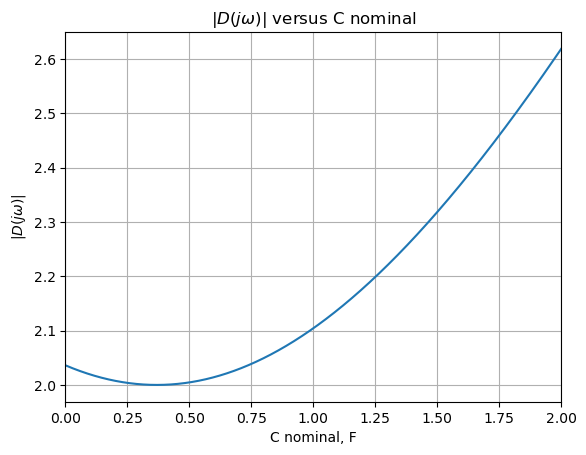

In [14]:
C_range = np.arange(1e-10,2,0.001)

plt.plot(C_range,f(C_range))

plt.title('$|D(j\omega)|$ versus C nominal')
plt.ylabel('$|D(j\omega)|$')
plt.xlabel('C nominal, F')
plt.xlim((0,2))
plt.grid()

plt.show()

The plot shows that $\vert D(j\omega) \vert$ is at a minimum for $C \approx 0.4$. 

The idea is that when $\vert D(j\omega) \vert$ is minimized, $\vert H(s) \vert$ will be maximized, so it's this value of $C$ that we want to use in the filter. We can use the `argmin` function to find this location on the curve.  

In [15]:
C_normalized_value = C_range[np.argmin(f(C_range))]
print(f'|D(s)| minimum = {f(C_range).min():.2f} is at C = {C_normalized_value:.3f}')

|D(s)| minimum = 2.00 is at C = 0.368


The normalized value $C=0.368$ is put into the Python dictionary of normalized filter values. All the normalized values are displayed below.

In [16]:
normalized_element_values[C] = C_normalized_value

# display the normalized component values
for k,v in normalized_element_values.items():
    if str(k)[0] == 'C':
        print('{:s} = {:,.2f} F'.format(str(k), v))
    elif str(k)[0] == 'L':
        print('{:s} = {:,.1f} H'.format(str(k), v))
    elif str(k)[0] == 'R':
        print('{:s} = {:.1f} ohms'.format(str(k), v))        

R1 = 1.0 ohms
R2 = 1.0 ohms
L1 = 1.1 H
L2 = 1.1 H
C1 = 1.10 F
C2 = 1.10 F
C = 0.37 F


## 4) Frequency and Impedance Scaling of the Normalized Values
The normalized component values are now scaled for frequency and impedance. The filter is intended to act as a pre-selection filter for the Ham bands by attenuating out of band signals. The frequency range for each HF Ham band is displayed in the table below.

| Band Name | Frequency Range, MHz |
|:---|:---|
| 160 Meters | 1.8 - 2.0 |
| 80 Meters | 3.5 - 4.0 |
| 40 Meters | 7.0 - 7.3 |
| 20 Meters | 14.0 - 14.35 |
| 15 Meters | 21.0 - 21.45 |
| 10 Meters |28.0 - 29.7 |

Frequency response of the BPF has geometric symmetry (i.e. when plotted on a logarithmic scale) and the BPF center frequency is $f_o=\sqrt{f_1 f_2}$, where $f_1$ and $f_2$ are the frequencies from the table above.

In [17]:
Ham_band = {'160_meters':[1.8, 2.0], '80_meters': [3.5, 4.0], '40_meters': [7.0, 7.3], '20_meters': [14.0, 14.35], '15_meters': [21.0, 21.45], '10_meters': [28.0, 29.7]}

band = '40_meters'
f1 = Ham_band[band][0]*1e6 # lower frequency
f2 = Ham_band[band][1]*1e6 # upper frequency
fo = np.sqrt(f1*f2) # geometric center frequency. Hz
print(f'center frequency: {fo/1e6:,.3f} MHz')

center frequency: 7.148 MHz


The transition bandwidth and the stopband attenuation requirements determine the order of the filter. For the filter schematic shown above, the filter's $Q$ is probably the simplest way to describe the filter's bandwidth as a function of center frequency. For this filter, $Q=7$ is a value that produces reasonable results. For the lower HF bands a lower Q can be used since it will produce a wider filter that can cover more of the band.

In [18]:
R = 50 # terminating resistor values
Q = 7 # filter Q
Bw = fo/Q
print(f'filter bandwidth: {Bw/1e3:,.1f} kHz')

filter bandwidth: 1,021.2 kHz


The code below calculates the final component values from the normalized values. First the values for the series branch are calculated.  

In [19]:
Cn = normalized_element_values[C1]
C1_value = Bw/(2*np.pi*fo**2*Cn*R)
print(f'C1, C2: {C1_value*1e12:.3f} pF')

C1, C2: 57.829 pF


In [20]:
Ln = normalized_element_values[L1]
L1_value = R*Ln/(2*np.pi*Bw)
print(f'L1, L2: {L1_value*1e6:.3f} uH')

L1, L2: 8.572 uH


Next, the value of the shunt capacitor is calculated.

In [21]:
C_value = normalized_element_values[C]/(2*np.pi*R*Bw)
print(f'C: {C_value*1e12:,.3f} pF')

C: 1,147.058 pF


The final component values are put into a Python dictionary and are displayed below.

In [22]:
final_component_values = {R1: R, L1: L1_value, L2: L1_value, R2: R, C1: C1_value, C2: C1_value, C:C_value}

# display the component values
for k,v in final_component_values.items():
    if str(k)[0] == 'C':
        print('{:s} = {:,.3f} pF'.format(str(k), v*1e12))
    elif str(k)[0] == 'L':
        print('{:s} = {:,.3f} uH'.format(str(k), v*1e6))
    elif str(k)[0] == 'R':
        print('{:s} = {:.1f} ohms'.format(str(k), v))        

R1 = 50.0 ohms
L1 = 8.572 uH
L2 = 8.572 uH
R2 = 50.0 ohms
C1 = 57.829 pF
C2 = 57.829 pF
C = 1,147.058 pF


If you compare these component values with the values used in SV3ORA's filter, you will see that they really don't line up. While the inductor values fall within the range of 0.9 uH to 15 uH, a value of 8.57 uH can't be selected by any switch combination. The values of $C_1$ and $C_2$ do fall within the range of the 700pF variable capacitor. The shunt capacitor $C$ also dosen't fall within the range that can be selected by $SW_4$ and $SW_5$, but kind of close at 1147 vs 980 pF.

SV3ORA didn't describe his filter design process, so we can't work though his steps; and to reverse engineer his process would take a lot of trial and error. His spectrum analyzer plots are very confusing since the instrument settings appear to be different from one photo to the next and it's difficult to tell where the marker is. I doubt his filter is matched to 50 ohms at each band. Also, it's not clear what's the insertion loss is in each photo. I realize that most amateurs don't have access to a network analyzer, but plots of s-parameters taken for each of the switch settings would answer many questions I have about this filter.

## 5) Filter Frequency Response
Using a modified nodal analysis procedure implemented in Python, the frequency response of the filter, scaled to the 40 meter band, is displayed below. The details of the Python calculation can be found in the JupyterLab notebook, see the link above to find the GitHub repository.

---

Load the netlist. The component values are all set to one for now. 

In [23]:
net_list = '''
V1 1 0 1
R1 3 1 1
L1 3 4 1
C1 5 4 1
C 5 0 1
L2 6 2 1
C2 6 5 1
R2 2 0 1
'''

Call the symbolic modified nodal analysis function to generate the MNA matrices.

In [24]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

Assemble and display the network equations.

In [25]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

# turn the free symbols into SymPy variables.
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

# display the equations
temp = ''
for i in range(shape(NE_sym.lhs)[0]):
    temp += '${:s} = {:s}$<br>'.format(latex(NE_sym.rhs[i]),latex(NE_sym.lhs[i]))
Markdown(temp)

$0 = I_{V1} + \frac{v_{1}}{R_{1}} - \frac{v_{3}}{R_{1}}$<br>$0 = - I_{L2} + \frac{v_{2}}{R_{2}}$<br>$0 = I_{L1} - \frac{v_{1}}{R_{1}} + \frac{v_{3}}{R_{1}}$<br>$0 = C_{1} s v_{4} - C_{1} s v_{5} - I_{L1}$<br>$0 = - C_{1} s v_{4} - C_{2} s v_{6} + v_{5} \left(C s + C_{1} s + C_{2} s\right)$<br>$0 = - C_{2} s v_{5} + C_{2} s v_{6} + I_{L2}$<br>$V_{1} = v_{1}$<br>$0 = - I_{L1} L_{1} s + v_{3} - v_{4}$<br>$0 = - I_{L2} L_{2} s - v_{2} + v_{6}$<br>

Use the SymPy function `solve` to determine the unknown node voltages and device currents.

In [26]:
U_sym = solve(NE_sym,X)

temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = V_{1}$<br>$v_{2} = \frac{C_{1} C_{2} R_{2} V_{1} s}{C C_{1} C_{2} L_{1} L_{2} s^{4} + C C_{1} C_{2} L_{1} R_{2} s^{3} + C C_{1} C_{2} L_{2} R_{1} s^{3} + C C_{1} C_{2} R_{1} R_{2} s^{2} + C C_{1} L_{1} s^{2} + C C_{1} R_{1} s + C C_{2} L_{2} s^{2} + C C_{2} R_{2} s + C + C_{1} C_{2} L_{1} s^{2} + C_{1} C_{2} L_{2} s^{2} + C_{1} C_{2} R_{1} s + C_{1} C_{2} R_{2} s + C_{1} + C_{2}}$<br>$v_{3} = \frac{C C_{1} C_{2} L_{1} L_{2} V_{1} s^{4} + C C_{1} C_{2} L_{1} R_{2} V_{1} s^{3} + C C_{1} L_{1} V_{1} s^{2} + C C_{2} L_{2} V_{1} s^{2} + C C_{2} R_{2} V_{1} s + C V_{1} + C_{1} C_{2} L_{1} V_{1} s^{2} + C_{1} C_{2} L_{2} V_{1} s^{2} + C_{1} C_{2} R_{2} V_{1} s + C_{1} V_{1} + C_{2} V_{1}}{C C_{1} C_{2} L_{1} L_{2} s^{4} + C C_{1} C_{2} L_{1} R_{2} s^{3} + C C_{1} C_{2} L_{2} R_{1} s^{3} + C C_{1} C_{2} R_{1} R_{2} s^{2} + C C_{1} L_{1} s^{2} + C C_{1} R_{1} s + C C_{2} L_{2} s^{2} + C C_{2} R_{2} s + C + C_{1} C_{2} L_{1} s^{2} + C_{1} C_{2} L_{2} s^{2} + C_{1} C_{2} R_{1} s + C_{1} C_{2} R_{2} s + C_{1} + C_{2}}$<br>$v_{4} = \frac{C C_{2} L_{2} V_{1} s^{2} + C C_{2} R_{2} V_{1} s + C V_{1} + C_{1} C_{2} L_{2} V_{1} s^{2} + C_{1} C_{2} R_{2} V_{1} s + C_{1} V_{1} + C_{2} V_{1}}{C C_{1} C_{2} L_{1} L_{2} s^{4} + C C_{1} C_{2} L_{1} R_{2} s^{3} + C C_{1} C_{2} L_{2} R_{1} s^{3} + C C_{1} C_{2} R_{1} R_{2} s^{2} + C C_{1} L_{1} s^{2} + C C_{1} R_{1} s + C C_{2} L_{2} s^{2} + C C_{2} R_{2} s + C + C_{1} C_{2} L_{1} s^{2} + C_{1} C_{2} L_{2} s^{2} + C_{1} C_{2} R_{1} s + C_{1} C_{2} R_{2} s + C_{1} + C_{2}}$<br>$v_{5} = \frac{C_{1} C_{2} L_{2} V_{1} s^{2} + C_{1} C_{2} R_{2} V_{1} s + C_{1} V_{1}}{C C_{1} C_{2} L_{1} L_{2} s^{4} + C C_{1} C_{2} L_{1} R_{2} s^{3} + C C_{1} C_{2} L_{2} R_{1} s^{3} + C C_{1} C_{2} R_{1} R_{2} s^{2} + C C_{1} L_{1} s^{2} + C C_{1} R_{1} s + C C_{2} L_{2} s^{2} + C C_{2} R_{2} s + C + C_{1} C_{2} L_{1} s^{2} + C_{1} C_{2} L_{2} s^{2} + C_{1} C_{2} R_{1} s + C_{1} C_{2} R_{2} s + C_{1} + C_{2}}$<br>$v_{6} = \frac{C_{1} C_{2} L_{2} V_{1} s^{2} + C_{1} C_{2} R_{2} V_{1} s}{C C_{1} C_{2} L_{1} L_{2} s^{4} + C C_{1} C_{2} L_{1} R_{2} s^{3} + C C_{1} C_{2} L_{2} R_{1} s^{3} + C C_{1} C_{2} R_{1} R_{2} s^{2} + C C_{1} L_{1} s^{2} + C C_{1} R_{1} s + C C_{2} L_{2} s^{2} + C C_{2} R_{2} s + C + C_{1} C_{2} L_{1} s^{2} + C_{1} C_{2} L_{2} s^{2} + C_{1} C_{2} R_{1} s + C_{1} C_{2} R_{2} s + C_{1} + C_{2}}$<br>$I_{V1} = \frac{- C C_{1} C_{2} L_{2} V_{1} s^{3} - C C_{1} C_{2} R_{2} V_{1} s^{2} - C C_{1} V_{1} s - C_{1} C_{2} V_{1} s}{C C_{1} C_{2} L_{1} L_{2} s^{4} + C C_{1} C_{2} L_{1} R_{2} s^{3} + C C_{1} C_{2} L_{2} R_{1} s^{3} + C C_{1} C_{2} R_{1} R_{2} s^{2} + C C_{1} L_{1} s^{2} + C C_{1} R_{1} s + C C_{2} L_{2} s^{2} + C C_{2} R_{2} s + C + C_{1} C_{2} L_{1} s^{2} + C_{1} C_{2} L_{2} s^{2} + C_{1} C_{2} R_{1} s + C_{1} C_{2} R_{2} s + C_{1} + C_{2}}$<br>$I_{L1} = \frac{C C_{1} C_{2} L_{2} V_{1} s^{3} + C C_{1} C_{2} R_{2} V_{1} s^{2} + C C_{1} V_{1} s + C_{1} C_{2} V_{1} s}{C C_{1} C_{2} L_{1} L_{2} s^{4} + C C_{1} C_{2} L_{1} R_{2} s^{3} + C C_{1} C_{2} L_{2} R_{1} s^{3} + C C_{1} C_{2} R_{1} R_{2} s^{2} + C C_{1} L_{1} s^{2} + C C_{1} R_{1} s + C C_{2} L_{2} s^{2} + C C_{2} R_{2} s + C + C_{1} C_{2} L_{1} s^{2} + C_{1} C_{2} L_{2} s^{2} + C_{1} C_{2} R_{1} s + C_{1} C_{2} R_{2} s + C_{1} + C_{2}}$<br>$I_{L2} = \frac{C_{1} C_{2} V_{1} s}{C C_{1} C_{2} L_{1} L_{2} s^{4} + C C_{1} C_{2} L_{1} R_{2} s^{3} + C C_{1} C_{2} L_{2} R_{1} s^{3} + C C_{1} C_{2} R_{1} R_{2} s^{2} + C C_{1} L_{1} s^{2} + C C_{1} R_{1} s + C C_{2} L_{2} s^{2} + C C_{2} R_{2} s + C + C_{1} C_{2} L_{1} s^{2} + C_{1} C_{2} L_{2} s^{2} + C_{1} C_{2} R_{1} s + C_{1} C_{2} R_{2} s + C_{1} + C_{2}}$<br>

The symbolic transfer function, $H_{sym}=\frac {v_2}{v_1}$.

In [27]:
H_sym = (U_sym[v2]/U_sym[v1]).simplify().collect(s)
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{C_{1} C_{2} R_{2} s}{C C_{1} C_{2} L_{1} L_{2} s^{4} + C + C_{1} + C_{2} + s^{3} \left(C C_{1} C_{2} L_{1} R_{2} + C C_{1} C_{2} L_{2} R_{1}\right) + s^{2} \left(C C_{1} C_{2} R_{1} R_{2} + C C_{1} L_{1} + C C_{2} L_{2} + C_{1} C_{2} L_{1} + C_{1} C_{2} L_{2}\right) + s \left(C C_{1} R_{1} + C C_{2} R_{2} + C_{1} C_{2} R_{1} + C_{1} C_{2} R_{2}\right)}$

Put the filter's component values into the equations.

In [28]:
NE = NE_sym.subs(final_component_values)

Display the network equations with numerical component values.

In [29]:
temp = ''
for i in range(shape(NE.lhs)[0]):
    temp += '${:s} = {:s}$<br>'.format(latex(NE.rhs[i]),latex(NE.lhs[i]))

Markdown(temp)

$0 = I_{V1} + \frac{v_{1}}{50} - \frac{v_{3}}{50}$<br>$0 = - I_{L2} + \frac{v_{2}}{50}$<br>$0 = I_{L1} - \frac{v_{1}}{50} + \frac{v_{3}}{50}$<br>$0 = - I_{L1} + 5.78294353790996 \cdot 10^{-11} s v_{4} - 5.78294353790996 \cdot 10^{-11} s v_{5}$<br>$0 = - 5.78294353790996 \cdot 10^{-11} s v_{4} + 1.26271728770142 \cdot 10^{-9} s v_{5} - 5.78294353790996 \cdot 10^{-11} s v_{6}$<br>$0 = I_{L2} - 5.78294353790996 \cdot 10^{-11} s v_{5} + 5.78294353790996 \cdot 10^{-11} s v_{6}$<br>$V_{1} = v_{1}$<br>$0 = - 8.57176805906704 \cdot 10^{-6} I_{L1} s + v_{3} - v_{4}$<br>$0 = - 8.57176805906704 \cdot 10^{-6} I_{L2} s - v_{2} + v_{6}$<br>

Solve for voltages and currents and display the results.

In [30]:
U = solve(NE,X)

temp = ''
for i in U.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U[i]))

Markdown(temp)

$v_{1} = V_{1}$<br>$v_{2} = \frac{2.55145538045155 \cdot 10^{91} V_{1} s}{4.30075132407804 \cdot 10^{70} s^{4} + 5.01734449000728 \cdot 10^{77} s^{3} + 1.8373369531222 \cdot 10^{86} s^{2} + 1.06320166313073 \cdot 10^{93} s + 1.92675367386081 \cdot 10^{101}}$<br>$v_{3} = \frac{4.30075132407804 \cdot 10^{70} V_{1} s^{4} + 2.50867224500364 \cdot 10^{77} V_{1} s^{3} + 1.82270361127419 \cdot 10^{86} V_{1} s^{2} + 5.31600831565367 \cdot 10^{92} V_{1} s + 1.92675367386081 \cdot 10^{101} V_{1}}{4.30075132407804 \cdot 10^{70} s^{4} + 5.01734449000728 \cdot 10^{77} s^{3} + 1.8373369531222 \cdot 10^{86} s^{2} + 1.06320166313073 \cdot 10^{93} s + 1.92675367386081 \cdot 10^{101}}$<br>$v_{4} = \frac{9.11351805637097 \cdot 10^{85} V_{1} s^{2} + 5.31600831565367 \cdot 10^{92} V_{1} s + 1.92675367386081 \cdot 10^{101} V_{1}}{4.30075132407804 \cdot 10^{70} s^{4} + 5.01734449000728 \cdot 10^{77} s^{3} + 1.8373369531222 \cdot 10^{86} s^{2} + 1.06320166313073 \cdot 10^{93} s + 1.92675367386081 \cdot 10^{101}}$<br>$v_{5} = \frac{5.6474057987402 \cdot 10^{56} V_{1}}{5.55270936427852 \cdot 10^{42} s^{2} + 3.23895217766945 \cdot 10^{49} s + 1.23312235127092 \cdot 10^{58}}$<br>$v_{6} = \frac{4.37409674685787 \cdot 10^{84} V_{1} s^{2} + 2.55145538045155 \cdot 10^{91} V_{1} s}{4.30075132407804 \cdot 10^{70} s^{4} + 5.01734449000728 \cdot 10^{77} s^{3} + 1.8373369531222 \cdot 10^{86} s^{2} + 1.06320166313073 \cdot 10^{93} s + 1.92675367386081 \cdot 10^{101}}$<br>$I_{V1} = \frac{- 5.01734449000728 \cdot 10^{75} V_{1} s^{3} - 2.92666836960202 \cdot 10^{82} V_{1} s^{2} - 1.06320166313073 \cdot 10^{91} V_{1} s}{4.30075132407804 \cdot 10^{70} s^{4} + 5.01734449000728 \cdot 10^{77} s^{3} + 1.8373369531222 \cdot 10^{86} s^{2} + 1.06320166313073 \cdot 10^{93} s + 1.92675367386081 \cdot 10^{101}}$<br>$I_{L1} = \frac{5.01734449000728 \cdot 10^{75} V_{1} s^{3} + 2.92666836960202 \cdot 10^{82} V_{1} s^{2} + 1.06320166313073 \cdot 10^{91} V_{1} s}{4.30075132407804 \cdot 10^{70} s^{4} + 5.01734449000728 \cdot 10^{77} s^{3} + 1.8373369531222 \cdot 10^{86} s^{2} + 1.06320166313073 \cdot 10^{93} s + 1.92675367386081 \cdot 10^{101}}$<br>$I_{L2} = \frac{5.1029107609031 \cdot 10^{89} V_{1} s}{4.30075132407804 \cdot 10^{70} s^{4} + 5.01734449000728 \cdot 10^{77} s^{3} + 1.8373369531222 \cdot 10^{86} s^{2} + 1.06320166313073 \cdot 10^{93} s + 1.92675367386081 \cdot 10^{101}}$<br>

The transfer function:

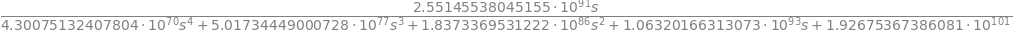

In [31]:
H = U[v2]/U[v1]
H

Use the function SciPy `bode` to calculate the frequency response.

In [32]:
H_num, H_denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)

x = np.logspace(6, 8, 2000, endpoint=False)*2*np.pi
w, mag, phase = signal.bode((a, b), w=x) # returns: rad/s, mag in dB, phase in deg

Plot the results.  

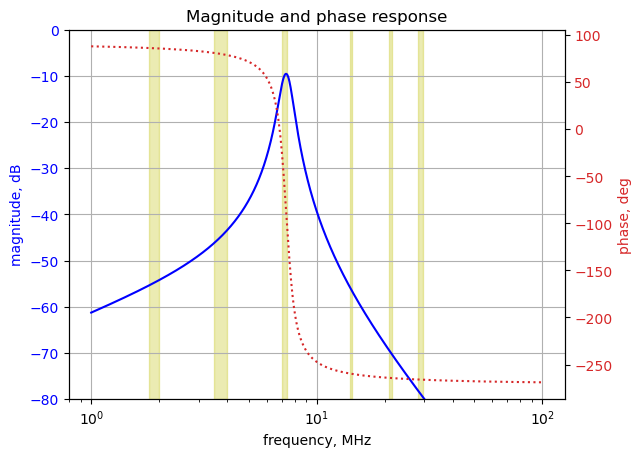

In [33]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('frequency, MHz')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylabel('magnitude, dB', color='b')
ax1.set_ylim((-80,0))
plt.semilogx(w/(2*np.pi)/1e6, mag,'-b') # Bode magnitude plot

# highlight the HF Ham bands
plt.axvspan(1.8, 2, color='y', alpha=0.3)
plt.axvspan(3.5, 4, color='y', alpha=0.3)
plt.axvspan(7, 7.36, color='y', alpha=0.3)
plt.axvspan(14, 14.35, color='y', alpha=0.3)
plt.axvspan(21, 21.45, color='y', alpha=0.3)
plt.axvspan(28, 29.7, color='y', alpha=0.3)

plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi)/1e6, phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase response')
plt.show()

In [34]:
print(f'peak: {mag.max():.2f} dB at {w[mag.argmax()]/(2*np.pi)/1e6:.3f} kHz')

peak: -9.59 dB at 7.311 kHz


In the plot above, the light yellow vertical bands are the locations of the HF Ham bands.

The filter design for the other amateur HF bands can proceed in a similar way as described above. After tabulating the component values for each band, some decisions can be made concerning the selection of discrete values to be combined by the switches.

## 6) Verify Solution with LTSpice
The filter was simulated in LTSpice and the frequency response of the filter agrees with the Python results.

## Question 2
> How do these shunt coupling capacitors change the filter topology and response, compared to a single LC band-pass?

I think you are asking what happens if $C_2$ and $L_2$ are removed from the filter. This question can be answered by simulating a new filter in a circuit simulator or analysing the circuit with loop analysis to get the transfer function. You can then compare the frequency response of each case.

## Question 3
> If I only used the series inductor + variable capacitor, the circuit would already behave as a tunable series resonant band-pass.

The filter performance will be different. Still a BPF, but if you overlay the frequency responce plots, you will see the difference.

## Question 4
> What changes mathematically when the second resonator and shunt coupling capacitors are present?

When you change the schematic, you will have a different netlist and therefore a different transfer function. The locations and number of poles and zeros will describe what is different mathematically.

## Question 5
> Do these changes make this circuit act something like a second order band-pass? Why? If I add as much resonator as I want with couplings without any reason does it still make a better filter?

As a general rule of thumb, the number of energy storage elements (i.e. capacitors and inductors) determine the order of the filter, unless the order of the filter is reduced by pole and zero cancellation. So a second order band pass filter would only have one capacitor and one inductor. Adding additional resonator branches, could improve some aspects of the filter provided the additional transfer function poles and zeros contributed in a meaningful way. Filter design handbooks will usually have a whole chapter devoted to band pass filters and by reading the material you will learn how to design a filter to meet your requirements.  

While SV3ORA's filter has a minimum number of components and can tune across the HF band, I would guess that the filter has substantially more insertion loss than canonical analog BP filters and exhibits impedance miss match on both ports. 


# Canonical BPF Design
The schematic shown below is a Butterworth BPF designed from a LP prototype. The normalized element values are from a filter design table.

![](BPF_prototype.png)

In [35]:
net_list = '''
V1 1 0 1
R1 3 1 1
L1 3 4 1
L2 6 2 1
R2 2 0 1
C1 5 4 1
C2 6 5 1
C3 0 5 2
L3 5 0 2
'''

Call the symbolic modified nodal analysis function to generate the MNA matrices.

In [36]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

Assemble and build the network equations.

In [37]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

# turn the free symbols into SymPy variables.
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

# display the equations
temp = ''
for i in range(shape(NE_sym.lhs)[0]):
    temp += '${:s} = {:s}$<br>'.format(latex(NE_sym.rhs[i]),latex(NE_sym.lhs[i]))
Markdown(temp)

$0 = I_{V1} + \frac{v_{1}}{R_{1}} - \frac{v_{3}}{R_{1}}$<br>$0 = - I_{L2} + \frac{v_{2}}{R_{2}}$<br>$0 = I_{L1} - \frac{v_{1}}{R_{1}} + \frac{v_{3}}{R_{1}}$<br>$0 = C_{1} s v_{4} - C_{1} s v_{5} - I_{L1}$<br>$0 = - C_{1} s v_{4} - C_{2} s v_{6} + I_{L3} + v_{5} \left(C_{1} s + C_{2} s + C_{3} s\right)$<br>$0 = - C_{2} s v_{5} + C_{2} s v_{6} + I_{L2}$<br>$V_{1} = v_{1}$<br>$0 = - I_{L1} L_{1} s + v_{3} - v_{4}$<br>$0 = - I_{L2} L_{2} s - v_{2} + v_{6}$<br>$0 = - I_{L3} L_{3} s + v_{5}$<br>

Use the SymPy function `solve` to determine the unknown node voltages and device currents.

In [38]:
U_sym = solve(NE_sym,X)

temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = V_{1}$<br>$v_{2} = \frac{C_{1} C_{2} L_{3} R_{2} V_{1} s^{3}}{C_{1} C_{2} C_{3} L_{1} L_{2} L_{3} s^{6} + C_{1} C_{2} C_{3} L_{1} L_{3} R_{2} s^{5} + C_{1} C_{2} C_{3} L_{2} L_{3} R_{1} s^{5} + C_{1} C_{2} C_{3} L_{3} R_{1} R_{2} s^{4} + C_{1} C_{2} L_{1} L_{2} s^{4} + C_{1} C_{2} L_{1} L_{3} s^{4} + C_{1} C_{2} L_{1} R_{2} s^{3} + C_{1} C_{2} L_{2} L_{3} s^{4} + C_{1} C_{2} L_{2} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{2} s^{3} + C_{1} C_{2} R_{1} R_{2} s^{2} + C_{1} C_{3} L_{1} L_{3} s^{4} + C_{1} C_{3} L_{3} R_{1} s^{3} + C_{1} L_{1} s^{2} + C_{1} L_{3} s^{2} + C_{1} R_{1} s + C_{2} C_{3} L_{2} L_{3} s^{4} + C_{2} C_{3} L_{3} R_{2} s^{3} + C_{2} L_{2} s^{2} + C_{2} L_{3} s^{2} + C_{2} R_{2} s + C_{3} L_{3} s^{2} + 1}$<br>$v_{3} = \frac{C_{1} C_{2} C_{3} L_{1} L_{2} L_{3} V_{1} s^{6} + C_{1} C_{2} C_{3} L_{1} L_{3} R_{2} V_{1} s^{5} + C_{1} C_{2} L_{1} L_{2} V_{1} s^{4} + C_{1} C_{2} L_{1} L_{3} V_{1} s^{4} + C_{1} C_{2} L_{1} R_{2} V_{1} s^{3} + C_{1} C_{2} L_{2} L_{3} V_{1} s^{4} + C_{1} C_{2} L_{3} R_{2} V_{1} s^{3} + C_{1} C_{3} L_{1} L_{3} V_{1} s^{4} + C_{1} L_{1} V_{1} s^{2} + C_{1} L_{3} V_{1} s^{2} + C_{2} C_{3} L_{2} L_{3} V_{1} s^{4} + C_{2} C_{3} L_{3} R_{2} V_{1} s^{3} + C_{2} L_{2} V_{1} s^{2} + C_{2} L_{3} V_{1} s^{2} + C_{2} R_{2} V_{1} s + C_{3} L_{3} V_{1} s^{2} + V_{1}}{C_{1} C_{2} C_{3} L_{1} L_{2} L_{3} s^{6} + C_{1} C_{2} C_{3} L_{1} L_{3} R_{2} s^{5} + C_{1} C_{2} C_{3} L_{2} L_{3} R_{1} s^{5} + C_{1} C_{2} C_{3} L_{3} R_{1} R_{2} s^{4} + C_{1} C_{2} L_{1} L_{2} s^{4} + C_{1} C_{2} L_{1} L_{3} s^{4} + C_{1} C_{2} L_{1} R_{2} s^{3} + C_{1} C_{2} L_{2} L_{3} s^{4} + C_{1} C_{2} L_{2} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{2} s^{3} + C_{1} C_{2} R_{1} R_{2} s^{2} + C_{1} C_{3} L_{1} L_{3} s^{4} + C_{1} C_{3} L_{3} R_{1} s^{3} + C_{1} L_{1} s^{2} + C_{1} L_{3} s^{2} + C_{1} R_{1} s + C_{2} C_{3} L_{2} L_{3} s^{4} + C_{2} C_{3} L_{3} R_{2} s^{3} + C_{2} L_{2} s^{2} + C_{2} L_{3} s^{2} + C_{2} R_{2} s + C_{3} L_{3} s^{2} + 1}$<br>$v_{4} = \frac{C_{1} C_{2} L_{2} L_{3} V_{1} s^{4} + C_{1} C_{2} L_{3} R_{2} V_{1} s^{3} + C_{1} L_{3} V_{1} s^{2} + C_{2} C_{3} L_{2} L_{3} V_{1} s^{4} + C_{2} C_{3} L_{3} R_{2} V_{1} s^{3} + C_{2} L_{2} V_{1} s^{2} + C_{2} L_{3} V_{1} s^{2} + C_{2} R_{2} V_{1} s + C_{3} L_{3} V_{1} s^{2} + V_{1}}{C_{1} C_{2} C_{3} L_{1} L_{2} L_{3} s^{6} + C_{1} C_{2} C_{3} L_{1} L_{3} R_{2} s^{5} + C_{1} C_{2} C_{3} L_{2} L_{3} R_{1} s^{5} + C_{1} C_{2} C_{3} L_{3} R_{1} R_{2} s^{4} + C_{1} C_{2} L_{1} L_{2} s^{4} + C_{1} C_{2} L_{1} L_{3} s^{4} + C_{1} C_{2} L_{1} R_{2} s^{3} + C_{1} C_{2} L_{2} L_{3} s^{4} + C_{1} C_{2} L_{2} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{2} s^{3} + C_{1} C_{2} R_{1} R_{2} s^{2} + C_{1} C_{3} L_{1} L_{3} s^{4} + C_{1} C_{3} L_{3} R_{1} s^{3} + C_{1} L_{1} s^{2} + C_{1} L_{3} s^{2} + C_{1} R_{1} s + C_{2} C_{3} L_{2} L_{3} s^{4} + C_{2} C_{3} L_{3} R_{2} s^{3} + C_{2} L_{2} s^{2} + C_{2} L_{3} s^{2} + C_{2} R_{2} s + C_{3} L_{3} s^{2} + 1}$<br>$v_{5} = \frac{C_{1} C_{2} L_{2} L_{3} V_{1} s^{4} + C_{1} C_{2} L_{3} R_{2} V_{1} s^{3} + C_{1} L_{3} V_{1} s^{2}}{C_{1} C_{2} C_{3} L_{1} L_{2} L_{3} s^{6} + C_{1} C_{2} C_{3} L_{1} L_{3} R_{2} s^{5} + C_{1} C_{2} C_{3} L_{2} L_{3} R_{1} s^{5} + C_{1} C_{2} C_{3} L_{3} R_{1} R_{2} s^{4} + C_{1} C_{2} L_{1} L_{2} s^{4} + C_{1} C_{2} L_{1} L_{3} s^{4} + C_{1} C_{2} L_{1} R_{2} s^{3} + C_{1} C_{2} L_{2} L_{3} s^{4} + C_{1} C_{2} L_{2} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{2} s^{3} + C_{1} C_{2} R_{1} R_{2} s^{2} + C_{1} C_{3} L_{1} L_{3} s^{4} + C_{1} C_{3} L_{3} R_{1} s^{3} + C_{1} L_{1} s^{2} + C_{1} L_{3} s^{2} + C_{1} R_{1} s + C_{2} C_{3} L_{2} L_{3} s^{4} + C_{2} C_{3} L_{3} R_{2} s^{3} + C_{2} L_{2} s^{2} + C_{2} L_{3} s^{2} + C_{2} R_{2} s + C_{3} L_{3} s^{2} + 1}$<br>$v_{6} = \frac{C_{1} C_{2} L_{2} L_{3} V_{1} s^{4} + C_{1} C_{2} L_{3} R_{2} V_{1} s^{3}}{C_{1} C_{2} C_{3} L_{1} L_{2} L_{3} s^{6} + C_{1} C_{2} C_{3} L_{1} L_{3} R_{2} s^{5} + C_{1} C_{2} C_{3} L_{2} L_{3} R_{1} s^{5} + C_{1} C_{2} C_{3} L_{3} R_{1} R_{2} s^{4} + C_{1} C_{2} L_{1} L_{2} s^{4} + C_{1} C_{2} L_{1} L_{3} s^{4} + C_{1} C_{2} L_{1} R_{2} s^{3} + C_{1} C_{2} L_{2} L_{3} s^{4} + C_{1} C_{2} L_{2} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{2} s^{3} + C_{1} C_{2} R_{1} R_{2} s^{2} + C_{1} C_{3} L_{1} L_{3} s^{4} + C_{1} C_{3} L_{3} R_{1} s^{3} + C_{1} L_{1} s^{2} + C_{1} L_{3} s^{2} + C_{1} R_{1} s + C_{2} C_{3} L_{2} L_{3} s^{4} + C_{2} C_{3} L_{3} R_{2} s^{3} + C_{2} L_{2} s^{2} + C_{2} L_{3} s^{2} + C_{2} R_{2} s + C_{3} L_{3} s^{2} + 1}$<br>$I_{V1} = \frac{- C_{1} C_{2} C_{3} L_{2} L_{3} V_{1} s^{5} - C_{1} C_{2} C_{3} L_{3} R_{2} V_{1} s^{4} - C_{1} C_{2} L_{2} V_{1} s^{3} - C_{1} C_{2} L_{3} V_{1} s^{3} - C_{1} C_{2} R_{2} V_{1} s^{2} - C_{1} C_{3} L_{3} V_{1} s^{3} - C_{1} V_{1} s}{C_{1} C_{2} C_{3} L_{1} L_{2} L_{3} s^{6} + C_{1} C_{2} C_{3} L_{1} L_{3} R_{2} s^{5} + C_{1} C_{2} C_{3} L_{2} L_{3} R_{1} s^{5} + C_{1} C_{2} C_{3} L_{3} R_{1} R_{2} s^{4} + C_{1} C_{2} L_{1} L_{2} s^{4} + C_{1} C_{2} L_{1} L_{3} s^{4} + C_{1} C_{2} L_{1} R_{2} s^{3} + C_{1} C_{2} L_{2} L_{3} s^{4} + C_{1} C_{2} L_{2} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{2} s^{3} + C_{1} C_{2} R_{1} R_{2} s^{2} + C_{1} C_{3} L_{1} L_{3} s^{4} + C_{1} C_{3} L_{3} R_{1} s^{3} + C_{1} L_{1} s^{2} + C_{1} L_{3} s^{2} + C_{1} R_{1} s + C_{2} C_{3} L_{2} L_{3} s^{4} + C_{2} C_{3} L_{3} R_{2} s^{3} + C_{2} L_{2} s^{2} + C_{2} L_{3} s^{2} + C_{2} R_{2} s + C_{3} L_{3} s^{2} + 1}$<br>$I_{L1} = \frac{C_{1} C_{2} C_{3} L_{2} L_{3} V_{1} s^{5} + C_{1} C_{2} C_{3} L_{3} R_{2} V_{1} s^{4} + C_{1} C_{2} L_{2} V_{1} s^{3} + C_{1} C_{2} L_{3} V_{1} s^{3} + C_{1} C_{2} R_{2} V_{1} s^{2} + C_{1} C_{3} L_{3} V_{1} s^{3} + C_{1} V_{1} s}{C_{1} C_{2} C_{3} L_{1} L_{2} L_{3} s^{6} + C_{1} C_{2} C_{3} L_{1} L_{3} R_{2} s^{5} + C_{1} C_{2} C_{3} L_{2} L_{3} R_{1} s^{5} + C_{1} C_{2} C_{3} L_{3} R_{1} R_{2} s^{4} + C_{1} C_{2} L_{1} L_{2} s^{4} + C_{1} C_{2} L_{1} L_{3} s^{4} + C_{1} C_{2} L_{1} R_{2} s^{3} + C_{1} C_{2} L_{2} L_{3} s^{4} + C_{1} C_{2} L_{2} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{2} s^{3} + C_{1} C_{2} R_{1} R_{2} s^{2} + C_{1} C_{3} L_{1} L_{3} s^{4} + C_{1} C_{3} L_{3} R_{1} s^{3} + C_{1} L_{1} s^{2} + C_{1} L_{3} s^{2} + C_{1} R_{1} s + C_{2} C_{3} L_{2} L_{3} s^{4} + C_{2} C_{3} L_{3} R_{2} s^{3} + C_{2} L_{2} s^{2} + C_{2} L_{3} s^{2} + C_{2} R_{2} s + C_{3} L_{3} s^{2} + 1}$<br>$I_{L2} = \frac{C_{1} C_{2} L_{3} V_{1} s^{3}}{C_{1} C_{2} C_{3} L_{1} L_{2} L_{3} s^{6} + C_{1} C_{2} C_{3} L_{1} L_{3} R_{2} s^{5} + C_{1} C_{2} C_{3} L_{2} L_{3} R_{1} s^{5} + C_{1} C_{2} C_{3} L_{3} R_{1} R_{2} s^{4} + C_{1} C_{2} L_{1} L_{2} s^{4} + C_{1} C_{2} L_{1} L_{3} s^{4} + C_{1} C_{2} L_{1} R_{2} s^{3} + C_{1} C_{2} L_{2} L_{3} s^{4} + C_{1} C_{2} L_{2} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{2} s^{3} + C_{1} C_{2} R_{1} R_{2} s^{2} + C_{1} C_{3} L_{1} L_{3} s^{4} + C_{1} C_{3} L_{3} R_{1} s^{3} + C_{1} L_{1} s^{2} + C_{1} L_{3} s^{2} + C_{1} R_{1} s + C_{2} C_{3} L_{2} L_{3} s^{4} + C_{2} C_{3} L_{3} R_{2} s^{3} + C_{2} L_{2} s^{2} + C_{2} L_{3} s^{2} + C_{2} R_{2} s + C_{3} L_{3} s^{2} + 1}$<br>$I_{L3} = \frac{C_{1} C_{2} L_{2} V_{1} s^{3} + C_{1} C_{2} R_{2} V_{1} s^{2} + C_{1} V_{1} s}{C_{1} C_{2} C_{3} L_{1} L_{2} L_{3} s^{6} + C_{1} C_{2} C_{3} L_{1} L_{3} R_{2} s^{5} + C_{1} C_{2} C_{3} L_{2} L_{3} R_{1} s^{5} + C_{1} C_{2} C_{3} L_{3} R_{1} R_{2} s^{4} + C_{1} C_{2} L_{1} L_{2} s^{4} + C_{1} C_{2} L_{1} L_{3} s^{4} + C_{1} C_{2} L_{1} R_{2} s^{3} + C_{1} C_{2} L_{2} L_{3} s^{4} + C_{1} C_{2} L_{2} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{1} s^{3} + C_{1} C_{2} L_{3} R_{2} s^{3} + C_{1} C_{2} R_{1} R_{2} s^{2} + C_{1} C_{3} L_{1} L_{3} s^{4} + C_{1} C_{3} L_{3} R_{1} s^{3} + C_{1} L_{1} s^{2} + C_{1} L_{3} s^{2} + C_{1} R_{1} s + C_{2} C_{3} L_{2} L_{3} s^{4} + C_{2} C_{3} L_{3} R_{2} s^{3} + C_{2} L_{2} s^{2} + C_{2} L_{3} s^{2} + C_{2} R_{2} s + C_{3} L_{3} s^{2} + 1}$<br>

The symbolic transfer function, $H_{sym}=\frac {v_2}{v_1}$.

In [39]:
H_sym = (U_sym[v2]/U_sym[v1]).simplify().collect(s)
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{C_{1} C_{2} L_{3} R_{2} s^{3}}{C_{1} C_{2} C_{3} L_{1} L_{2} L_{3} s^{6} + s^{5} \left(C_{1} C_{2} C_{3} L_{1} L_{3} R_{2} + C_{1} C_{2} C_{3} L_{2} L_{3} R_{1}\right) + s^{4} \left(C_{1} C_{2} C_{3} L_{3} R_{1} R_{2} + C_{1} C_{2} L_{1} L_{2} + C_{1} C_{2} L_{1} L_{3} + C_{1} C_{2} L_{2} L_{3} + C_{1} C_{3} L_{1} L_{3} + C_{2} C_{3} L_{2} L_{3}\right) + s^{3} \left(C_{1} C_{2} L_{1} R_{2} + C_{1} C_{2} L_{2} R_{1} + C_{1} C_{2} L_{3} R_{1} + C_{1} C_{2} L_{3} R_{2} + C_{1} C_{3} L_{3} R_{1} + C_{2} C_{3} L_{3} R_{2}\right) + s^{2} \left(C_{1} C_{2} R_{1} R_{2} + C_{1} L_{1} + C_{1} L_{3} + C_{2} L_{2} + C_{2} L_{3} + C_{3} L_{3}\right) + s \left(C_{1} R_{1} + C_{2} R_{2}\right) + 1}$

The numerator and denominator of the transfer function can be obtained as follows:

In [40]:
H_sym_num, H_sym_denom = fraction(H_sym)

In [41]:
a3 = H_sym_num.coeff(s**3)
Markdown('$a_3={:s}$'.format(latex(a3)))

$a_3=C_{1} C_{2} L_{3} R_{2}$

In [42]:
H_sym_denom

The coefficients of each Laplace term can be equated to the variables $b_6$, $b_5$, $b_4$, $b_3$, $b_2$, $b_1$ and $b_0$ in the expression: 

$b_6s^6+b_5s^5+b_4s^4+b_3s^3+b_2s^2+b_1s+b_0$

where $b_6$, $b_5$, $b_4$, $b_3$, $b_2$, $b_1$ and $b_0$ are:

In [43]:
b6 = H_sym_denom.coeff(s**6)
b5 = H_sym_denom.coeff(s**5)
b4 = H_sym_denom.coeff(s**4)
b3 = H_sym_denom.coeff(s**3)
b2 = H_sym_denom.coeff(s**2)
b1 = H_sym_denom.coeff(s**1)
b0 = (H_sym_denom - b1*s*1 - b2*s**2 - b3*s**3 - b4*s**4 - b5*s**5 - b6*s**6).expand()
Markdown('<p>$b_6={:s}$</p><p>$b_5={:s}$</p><p>$b_4={:s}$</p><p>$b_3={:s}$</p><p>$b_2={:s}$</p><p>$b_1={:s}$</p><p>$b_0={:s}$</p>'.format(latex(b6),latex(b5),latex(b4),latex(b3),latex(b2),latex(b1),latex(b0)))

<p>$b_6=C_{1} C_{2} C_{3} L_{1} L_{2} L_{3}$</p><p>$b_5=C_{1} C_{2} C_{3} L_{1} L_{3} R_{2} + C_{1} C_{2} C_{3} L_{2} L_{3} R_{1}$</p><p>$b_4=C_{1} C_{2} C_{3} L_{3} R_{1} R_{2} + C_{1} C_{2} L_{1} L_{2} + C_{1} C_{2} L_{1} L_{3} + C_{1} C_{2} L_{2} L_{3} + C_{1} C_{3} L_{1} L_{3} + C_{2} C_{3} L_{2} L_{3}$</p><p>$b_3=C_{1} C_{2} L_{1} R_{2} + C_{1} C_{2} L_{2} R_{1} + C_{1} C_{2} L_{3} R_{1} + C_{1} C_{2} L_{3} R_{2} + C_{1} C_{3} L_{3} R_{1} + C_{2} C_{3} L_{3} R_{2}$</p><p>$b_2=C_{1} C_{2} R_{1} R_{2} + C_{1} L_{1} + C_{1} L_{3} + C_{2} L_{2} + C_{2} L_{3} + C_{3} L_{3}$</p><p>$b_1=C_{1} R_{1} + C_{2} R_{2}$</p><p>$b_0=1$</p>

## Scale element values

In [44]:
# select the Ham band
band = '40_meters'

f1 = Ham_band[band][0]*1e6 # lower frequency
f2 = Ham_band[band][1]*1e6 # upper frequency
fo = np.sqrt(f1*f2) # filter geometric center frequency. Hz
print(f'center frequency: {fo/1e6:,.3f} MHz')

center frequency: 7.148 MHz


Setting $Q = 7$, find the bandwidth, $Bw$.

In [45]:
R = 50 # terminating resistor values
Q = 7 # filter Q
Bw = fo/Q
print(f'bandwidth: {Bw:,.1f} Hz')

bandwidth: 1,021,203.8 Hz


Frequency and impedance scale the series resonant branches.

In [46]:
Cn_ser = 1
Cser_value = Bw/(2*np.pi*fo**2*Cn_ser*R)
print(f'C1, C2: {Cser_value*1e12:.3f} pF')

C1, C2: 63.612 pF


In [47]:
Ln_ser = 1
Lser_value = R*Ln_ser/(2*np.pi*Bw)
print(f'L1, L2: {Lser_value*1e6:.3f} uH')

L1, L2: 7.793 uH


Frequency and impedance scale the parallel resonant branches.

In [48]:
Cn_par = 2
Cpar_value = Cn_par/(2*np.pi*R*Bw)
print(f'C3: {Cpar_value*1e12:,.3f} pF')

C3: 6,234.013 pF


In [49]:
Ln_par = 2
Lpar_value = R*Bw/(2*np.pi*fo**2*Ln_par)
print(f'L3: {Lpar_value*1e6:.3f} uH')

L3: 0.080 uH


In [50]:
final_component_values = {R1:R, R2:R, L1:Lser_value, L2:Lser_value, L3:Lpar_value, C1:Cser_value, C2:Cser_value, C3:Cpar_value}

# display the component values
for k,v in final_component_values.items():
    if str(k)[0] == 'C':
        print('{:s} = {:,.3f} pF'.format(str(k), v*1e12))
    elif str(k)[0] == 'L':
        print('{:s} = {:,.3f} uH'.format(str(k), v*1e6))
    elif str(k)[0] == 'R':
        print('{:s} = {:.1f} ohms'.format(str(k), v))        

R1 = 50.0 ohms
R2 = 50.0 ohms
L1 = 7.793 uH
L2 = 7.793 uH
L3 = 0.080 uH
C1 = 63.612 pF
C2 = 63.612 pF
C3 = 6,234.013 pF


Put the component values into the equations.

In [51]:
NE = NE_sym.subs(final_component_values)

Display the network equations with numerical component values.

In [52]:
temp = ''
for i in range(shape(NE.lhs)[0]):
    temp += '${:s} = {:s}$<br>'.format(latex(NE.rhs[i]),latex(NE.lhs[i]))

Markdown(temp)

$0 = I_{V1} + \frac{v_{1}}{50} - \frac{v_{3}}{50}$<br>$0 = - I_{L2} + \frac{v_{2}}{50}$<br>$0 = I_{L1} - \frac{v_{1}}{50} + \frac{v_{3}}{50}$<br>$0 = - I_{L1} + 6.36123789170095 \cdot 10^{-11} s v_{4} - 6.36123789170095 \cdot 10^{-11} s v_{5}$<br>$0 = I_{L3} - 6.36123789170095 \cdot 10^{-11} s v_{4} + 6.36123789170095 \cdot 10^{-9} s v_{5} - 6.36123789170095 \cdot 10^{-11} s v_{6}$<br>$0 = I_{L2} - 6.36123789170095 \cdot 10^{-11} s v_{5} + 6.36123789170095 \cdot 10^{-11} s v_{6}$<br>$V_{1} = v_{1}$<br>$0 = - 7.79251641733367 \cdot 10^{-6} I_{L1} s + v_{3} - v_{4}$<br>$0 = - 7.79251641733367 \cdot 10^{-6} I_{L2} s - v_{2} + v_{6}$<br>$0 = - 7.95154736462619 \cdot 10^{-8} I_{L3} s + v_{5}$<br>

Solve for voltages and currents and display the results.

In [53]:
U = solve(NE,X)

temp = ''
for i in U.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U[i]))

Markdown(temp)

$v_{1} = V_{1}$<br>$v_{2} = \frac{6.43524254780172 \cdot 10^{108} V_{1} s^{3}}{4.87212117091262 \cdot 10^{88} s^{6} + 6.252307868194 \cdot 10^{95} s^{5} + 2.98874529891484 \cdot 10^{104} s^{4} + 2.53548556383388 \cdot 10^{111} s^{3} + 6.02933677970698 \cdot 10^{119} s^{2} + 2.54449515668038 \cdot 10^{126} s + 4.0 \cdot 10^{134}}$<br>$v_{3} = \frac{4.87212117091262 \cdot 10^{88} V_{1} s^{6} + 3.126153934097 \cdot 10^{95} V_{1} s^{5} + 2.96868660563353 \cdot 10^{104} V_{1} s^{4} + 1.26774278191694 \cdot 10^{111} V_{1} s^{3} + 5.98887143219217 \cdot 10^{119} V_{1} s^{2} + 1.27224757834019 \cdot 10^{126} V_{1} s + 4.0 \cdot 10^{134} V_{1}}{4.87212117091262 \cdot 10^{88} s^{6} + 6.252307868194 \cdot 10^{95} s^{5} + 2.98874529891484 \cdot 10^{104} s^{4} + 2.53548556383388 \cdot 10^{111} s^{3} + 6.02933677970698 \cdot 10^{119} s^{2} + 2.54449515668038 \cdot 10^{126} s + 4.0 \cdot 10^{134}}$<br>$v_{4} = \frac{9.92905317424727 \cdot 10^{103} V_{1} s^{4} + 6.3708901223237 \cdot 10^{110} V_{1} s^{3} + 4.00606940396638 \cdot 10^{119} V_{1} s^{2} + 1.27224757834019 \cdot 10^{126} V_{1} s + 4.0 \cdot 10^{134} V_{1}}{4.87212117091262 \cdot 10^{88} s^{6} + 6.252307868194 \cdot 10^{95} s^{5} + 2.98874529891484 \cdot 10^{104} s^{4} + 2.53548556383388 \cdot 10^{111} s^{3} + 6.02933677970698 \cdot 10^{119} s^{2} + 2.54449515668038 \cdot 10^{126} s + 4.0 \cdot 10^{134}}$<br>$v_{5} = \frac{1.0116336878703 \cdot 10^{73} V_{1} s^{2}}{4.91437985392037 \cdot 10^{59} s^{4} + 3.15326884842284 \cdot 10^{66} s^{3} + 2.00303470198319 \cdot 10^{75} s^{2} + 6.36123789170095 \cdot 10^{81} s + 2.0 \cdot 10^{90}}$<br>$v_{6} = \frac{1.00293466406538 \cdot 10^{102} V_{1} s^{4} + 6.43524254780172 \cdot 10^{108} V_{1} s^{3}}{4.87212117091262 \cdot 10^{88} s^{6} + 6.252307868194 \cdot 10^{95} s^{5} + 2.98874529891484 \cdot 10^{104} s^{4} + 2.53548556383388 \cdot 10^{111} s^{3} + 6.02933677970698 \cdot 10^{119} s^{2} + 2.54449515668038 \cdot 10^{126} s + 4.0 \cdot 10^{134}}$<br>$I_{V1} = \frac{- 6.252307868194 \cdot 10^{93} V_{1} s^{5} - 4.01173865626152 \cdot 10^{100} V_{1} s^{4} - 2.53548556383388 \cdot 10^{109} V_{1} s^{3} - 8.09306950296239 \cdot 10^{115} V_{1} s^{2} - 2.54449515668038 \cdot 10^{124} V_{1} s}{4.87212117091262 \cdot 10^{88} s^{6} + 6.252307868194 \cdot 10^{95} s^{5} + 2.98874529891484 \cdot 10^{104} s^{4} + 2.53548556383388 \cdot 10^{111} s^{3} + 6.02933677970698 \cdot 10^{119} s^{2} + 2.54449515668038 \cdot 10^{126} s + 4.0 \cdot 10^{134}}$<br>$I_{L1} = \frac{6.252307868194 \cdot 10^{93} V_{1} s^{5} + 4.01173865626152 \cdot 10^{100} V_{1} s^{4} + 2.53548556383388 \cdot 10^{109} V_{1} s^{3} + 8.09306950296239 \cdot 10^{115} V_{1} s^{2} + 2.54449515668038 \cdot 10^{124} V_{1} s}{4.87212117091262 \cdot 10^{88} s^{6} + 6.252307868194 \cdot 10^{95} s^{5} + 2.98874529891484 \cdot 10^{104} s^{4} + 2.53548556383388 \cdot 10^{111} s^{3} + 6.02933677970698 \cdot 10^{119} s^{2} + 2.54449515668038 \cdot 10^{126} s + 4.0 \cdot 10^{134}}$<br>$I_{L2} = \frac{1.28704850956034 \cdot 10^{107} V_{1} s^{3}}{4.87212117091262 \cdot 10^{88} s^{6} + 6.252307868194 \cdot 10^{95} s^{5} + 2.98874529891484 \cdot 10^{104} s^{4} + 2.53548556383388 \cdot 10^{111} s^{3} + 6.02933677970698 \cdot 10^{119} s^{2} + 2.54449515668038 \cdot 10^{126} s + 4.0 \cdot 10^{134}}$<br>$I_{L3} = \frac{1.27224757834019 \cdot 10^{80} V_{1} s}{4.91437985392037 \cdot 10^{59} s^{4} + 3.15326884842284 \cdot 10^{66} s^{3} + 2.00303470198319 \cdot 10^{75} s^{2} + 6.36123789170095 \cdot 10^{81} s + 2.0 \cdot 10^{90}}$<br>

Plot the frequency response of the transfer function

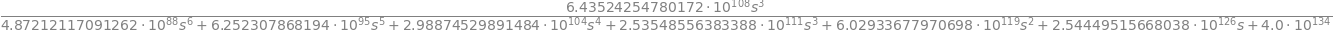

In [54]:
H = U[v2]/U[v1]
H

Use the SciPy function `bode` to get the magnitude and phase of the transfer function.

In [55]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)

x = np.logspace(6, 8, 2000, endpoint=False)*2*np.pi
w, mag, phase = signal.bode((a, b), w=x) # returns: rad/s, mag in dB, phase in deg

Plot the transfer function.

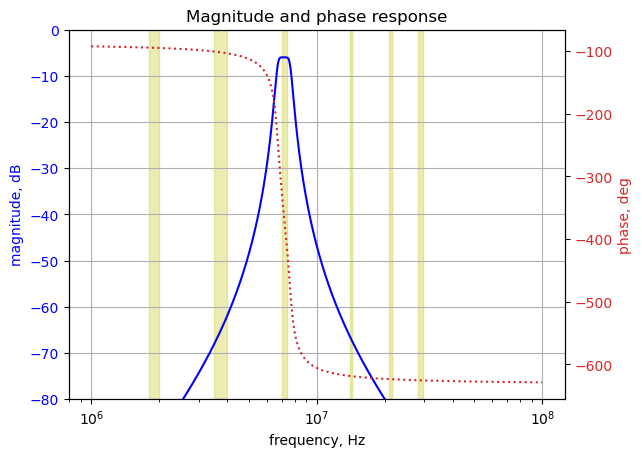

In [56]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('frequency, Hz')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylabel('magnitude, dB', color='b')
ax1.set_ylim((-80,0))
plt.semilogx(w/(2*np.pi), mag,'-b') # Bode magnitude plot

# highlight the HF Ham bands
plt.axvspan(1.8e6, 2e6, color='y', alpha=0.3)
plt.axvspan(3.5e6, 4e6, color='y', alpha=0.3)
plt.axvspan(7e6, 7.36e6, color='y', alpha=0.3)
plt.axvspan(14e6, 14.35e6, color='y', alpha=0.3)
plt.axvspan(21e6, 21.45e6, color='y', alpha=0.3)
plt.axvspan(28e6, 29.7e6, color='y', alpha=0.3)

plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase response')
plt.show()

In [57]:
print(f'peak: {mag.max():.2f} dB at {w[mag.argmax()]/(2*np.pi)/1e6:.3f} kHz')

peak: -6.02 dB at 7.145 kHz


The poles and zeros of the transfer function can easily be obtained with the following code:

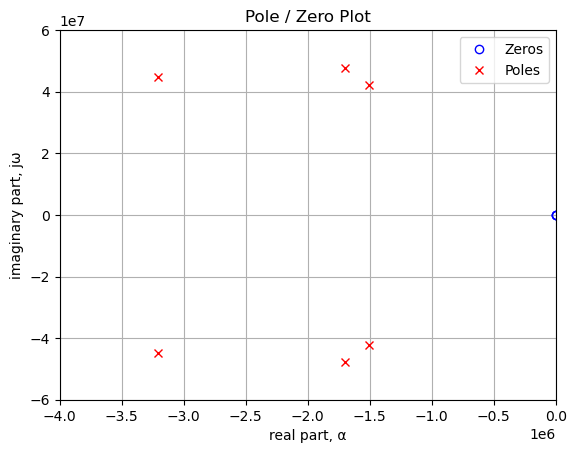

In [58]:
sys = signal.TransferFunction(a,b)

sys_zeros = np.roots(sys.num)
sys_poles = np.roots(sys.den)

plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.xlim((-4e6,0))
plt.ylim((-6e7,6e7))
plt.grid()
plt.show()

Poles and zeros of the transfer function plotted on the complex plane. The units are in radian frequency.

Printing these values in Hz.

In [59]:
print('number of zeros: {:d}'.format(len(sys_zeros)))
for i in sys_zeros:
    print('{:,.2f} Hz'.format(i/(2*np.pi)))

number of zeros: 3
0.00 Hz
0.00 Hz
0.00 Hz


In [60]:
print('number of poles: {:d}'.format(len(sys_poles)))
for i in sys_poles:
    print('{:,.2f} Hz'.format(i/(2*np.pi)))

number of poles: 6
-271,073.45+7,599,750.07j Hz
-271,073.45-7,599,750.07j Hz
-510,601.89+7,130,167.30j Hz
-510,601.89-7,130,167.30j Hz
-239,528.44+6,715,361.66j Hz
-239,528.44-6,715,361.66j Hz
